# Total Run

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
!pip install pmdarima
!pip install shap
!pip install bayesian-optimization
!pip install gluonts
!pip install mxnet
!pip install python-utils
!pip install cryptocmd
!python -m pip install prophet

In [7]:
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import shap
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from prophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import datetime


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.


2.9.2


The module gluonts.model.deepar has been moved to gluonts.mx.model.deepar. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import DeepAREstimator'.


In [ ]:
#Evaluation Metrics

import numpy as np
from sklearn.metrics import r2_score

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [ ]:
#Plots

import matplotlib.pyplot as plt
import pandas as pd


def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[color_dict.get(x, "#333333") for x in df.loc["mae"].sort_values().index],
    )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["rmse"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["mape"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    # plt.savefig("results/metrics.png")
    plt.show()

## Load Data and Manupulation

In [ ]:
from cryptocmd import CmcScraper

In [1]:
# initialise scraper without time interval
scraper = CmcScraper("BTC")
# get raw data as list of list
headers, data = scraper.get_data()
# get data in a json format
xrp_json_data = scraper.get_data("json")
# Pandas dataFrame for the same data
df_full = scraper.get_dataframe()
df_full['Date'] =  pd.to_datetime(df_full['Date'])

NameError: ignored

In [ ]:
df_full.drop(['Open','High','Low', 'Volume'],axis=1,inplace=True)

In [ ]:
a_7=[]
b_15=[]
c_30=[]
d_45=[]
e_60=[]
f_90=[]
base = datetime.datetime.today().date()
for x in range(0, 7):
      a_7.append(base + datetime.timedelta(days=x))
for x in range(0, 15):
      b_15.append(base + datetime.timedelta(days=x))
for x in range(0, 30):
      c_30.append(base + datetime.timedelta(days=x))
for x in range(0, 45):
      d_45.append(base + datetime.timedelta(days=x))
for x in range(0, 60):
      e_60.append(base + datetime.timedelta(days=x))
for x in range(0, 90):
      f_90.append(base + datetime.timedelta(days=x))
df_next7days = pd.DataFrame({"Date":a_7})
df_next15days = pd.DataFrame({"Date":b_15})
df_next30days = pd.DataFrame({"Date":c_30})
df_next45days = pd.DataFrame({"Date":d_45})
df_next60days = pd.DataFrame({"Date":e_60})
df_next90days = pd.DataFrame({"Date":f_90})

In [ ]:
week_ago_7 = datetime.date.today() - datetime.timedelta(days=7)
print("7 Days ago: ",week_ago_7.strftime('%Y-%m-%d'))
week_ago_15 = datetime.date.today() - datetime.timedelta(days=15)
print("15 Days ago: ",week_ago_15.strftime('%Y-%m-%d'))
week_ago_30 = datetime.date.today() - datetime.timedelta(days=30)
print("30 Days ago: ",week_ago_30.strftime('%Y-%m-%d'))
week_ago_45 = datetime.date.today() - datetime.timedelta(days=45)
print("45 Days ago: ",week_ago_45.strftime('%Y-%m-%d'))
week_ago_60 = datetime.date.today() - datetime.timedelta(days=60)
print("60 Days ago: ",week_ago_60.strftime('%Y-%m-%d'))
week_ago_90 = datetime.date.today() - datetime.timedelta(days=90)
print("90 Days ago: ",week_ago_90.strftime('%Y-%m-%d'))

7 Days ago:  2022-03-20
15 Days ago:  2022-03-12
30 Days ago:  2022-02-25
45 Days ago:  2022-02-10
60 Days ago:  2022-01-26
90 Days ago:  2021-12-27


In [ ]:
df = df_full[(df_full['Date'] >= '2021-01-01') & (df_full['Date'] <= datetime.date.today().strftime('%Y-%m-%d'))]
df_predict_7 = df_next7days.copy()
df_predict_15 = df_next15days.copy()
df_predict_30 = df_next30days.copy()
df_predict_45 = df_next45days.copy()
df_predict_60 = df_next60days.copy()
df_predict_90 = df_next90days.copy()

In [ ]:
df_full.index = df_full.Date
df_full.drop('Date',axis=1,inplace=True)

df.index = df.Date
df.drop('Date',axis=1,inplace=True)

df_predict_7.index = df_predict_7.Date
df_predict_7.drop('Date',axis=1,inplace=True)
df_predict_15.index = df_predict_15.Date
df_predict_15.drop('Date',axis=1,inplace=True)
df_predict_30.index = df_predict_30.Date
df_predict_30.drop('Date',axis=1,inplace=True)
df_predict_45.index = df_predict_45.Date
df_predict_45.drop('Date',axis=1,inplace=True)
df_predict_60.index = df_predict_60.Date
df_predict_60.drop('Date',axis=1,inplace=True)
df_predict_90.index = df_predict_90.Date
df_predict_90.drop('Date',axis=1,inplace=True)

In [ ]:
df_predict_7["Market Cap"] = df["Market Cap"].tolist()[:7]
df_predict_15["Market Cap"] = df["Market Cap"].tolist()[:15]
df_predict_30["Market Cap"] = df["Market Cap"].tolist()[:30]
df_predict_45["Market Cap"] = df["Market Cap"].tolist()[:45]
df_predict_60["Market Cap"] = df["Market Cap"].tolist()[:60]
df_predict_90["Market Cap"] = df["Market Cap"].tolist()[:90]

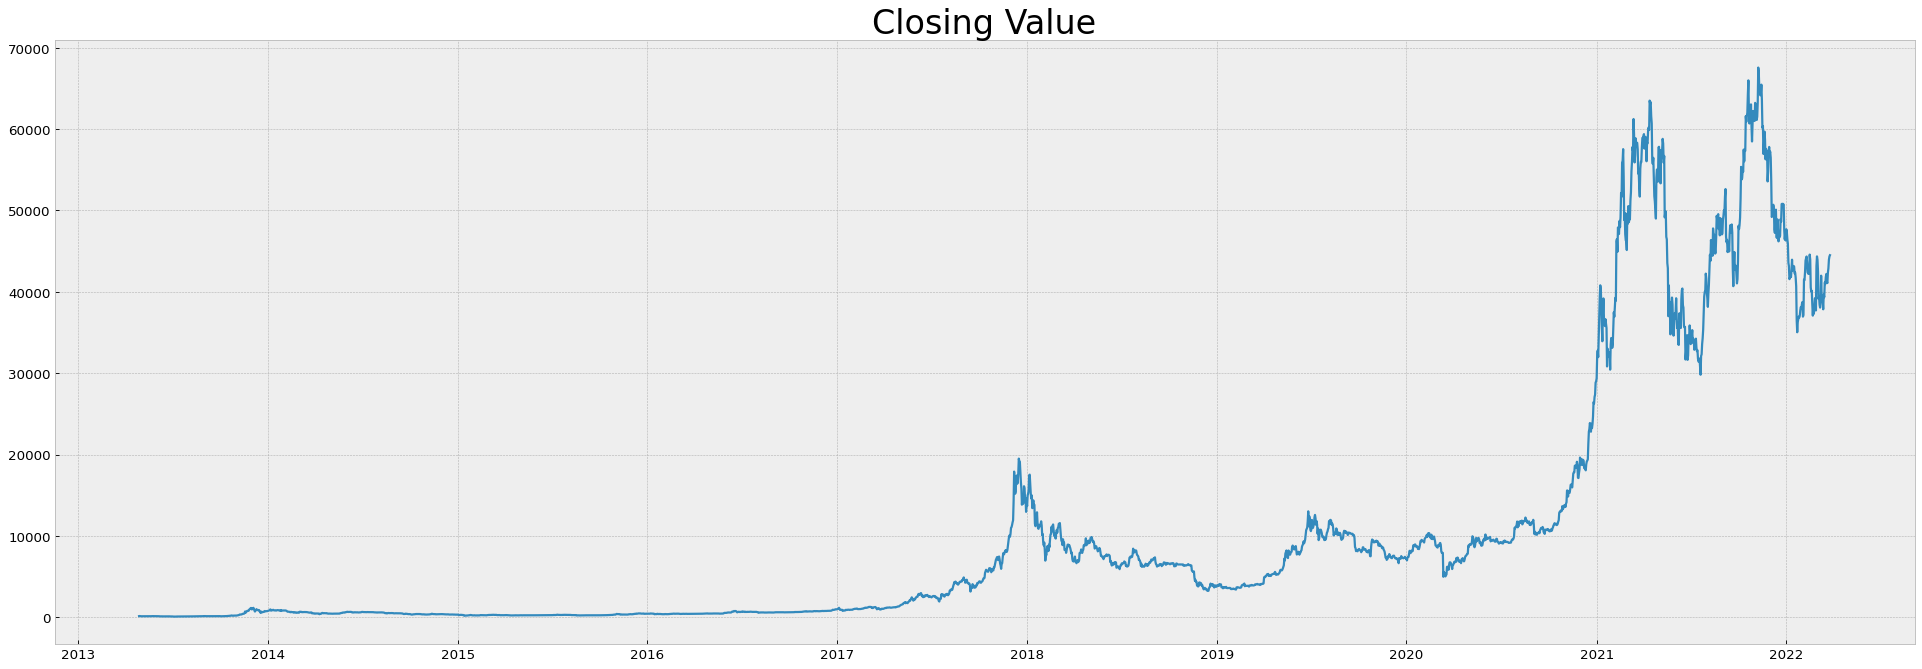

In [ ]:
#Data Understanding

plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Closing Value', fontsize=30)

plt.plot(df_full.Close)

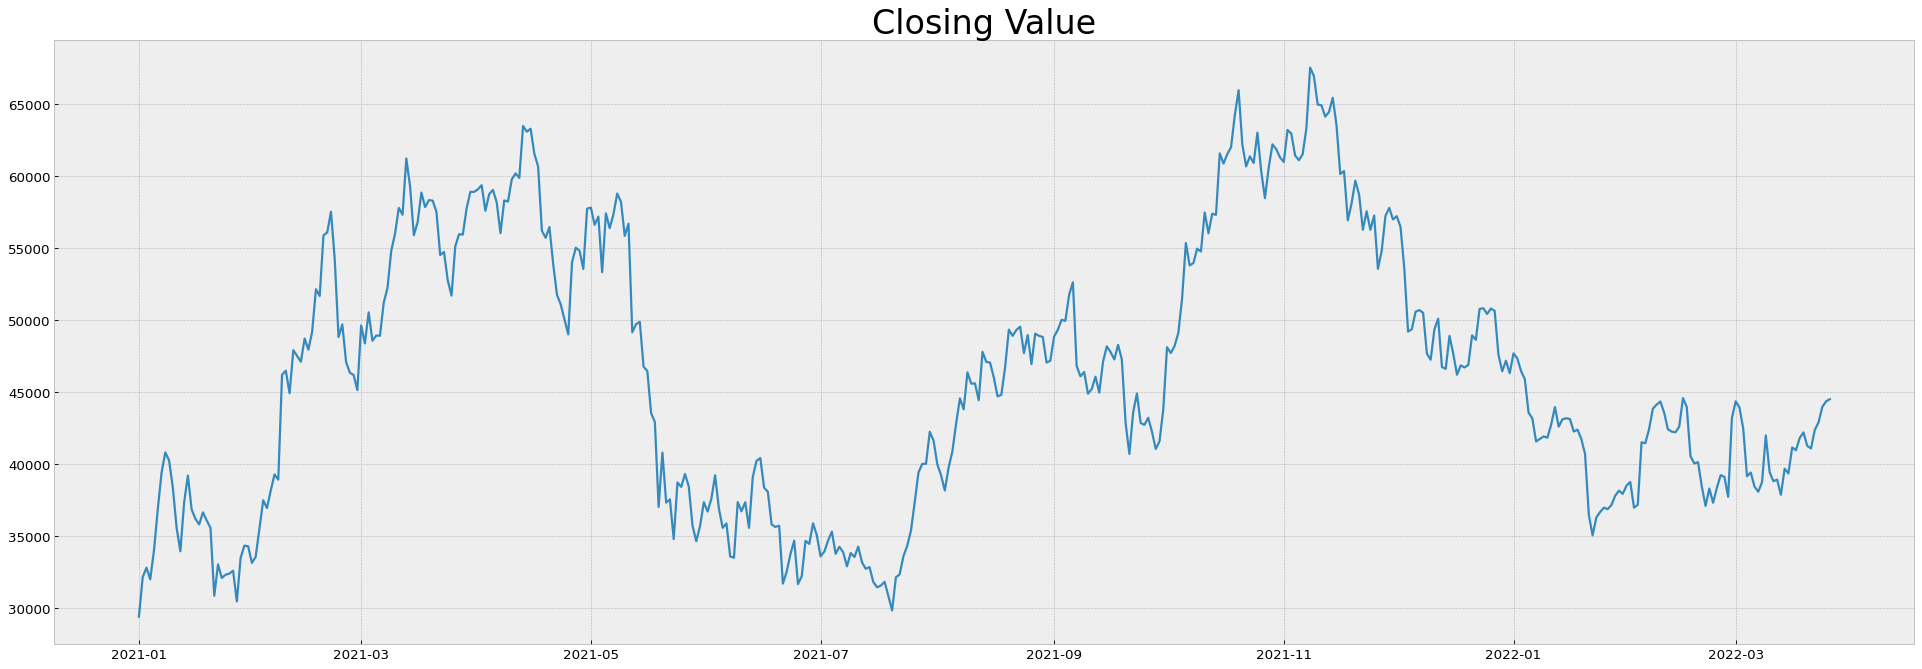

In [ ]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Closing Value', fontsize=30)

plt.plot(df.Close)

In [ ]:
df['Close:7 days rolling']=df['Close'].rolling(7).mean()
df['Market Cap:7 days rolling']=df['Market Cap'].rolling(7).mean()

df['Close:15 days rolling']=df['Close'].rolling(15).mean()
df['Market Cap:15 days rolling']=df['Market Cap'].rolling(15).mean()

df['Close:30 days rolling']=df['Close'].rolling(30).mean()
df['Market Cap:30 days rolling']=df['Market Cap'].rolling(30).mean()

df['Close:45 days rolling']=df['Close'].rolling(45).mean()
df['Market Cap:45 days rolling']=df['Market Cap'].rolling(45).mean()

df['Close:60 days rolling']=df['Close'].rolling(60).mean()
df['Market Cap:60 days rolling']=df['Market Cap'].rolling(60).mean()

df['Close:90 days rolling']=df['Close'].rolling(90).mean()
df['Market Cap:90 days rolling']=df['Market Cap'].rolling(90).mean()

In [ ]:
df.drop(['Market Cap','Close'],axis=1,inplace=True) 

In [ ]:
df_7 = df[['Close:7 days rolling', 'Market Cap:7 days rolling']]
df_15 = df[['Close:15 days rolling', 'Market Cap:15 days rolling']]
df_30 = df[['Close:30 days rolling', 'Market Cap:30 days rolling']]
df_45 = df[['Close:45 days rolling', 'Market Cap:45 days rolling']]
df_60 = df[['Close:60 days rolling', 'Market Cap:60 days rolling']]
df_90 = df[['Close:90 days rolling', 'Market Cap:90 days rolling']]

df_7.dropna(inplace=True)
df_15.dropna(inplace=True)
df_30.dropna(inplace=True)
df_45.dropna(inplace=True)
df_60.dropna(inplace=True)
df_90.dropna(inplace=True)

In [ ]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['date'] =  pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
X_train_df_7, y_train_7 = create_time_features(df_7, target='Close:7 days rolling')
X_test_df_7 = create_time_features(df_predict_7)

X_train_df_15, y_train_15 = create_time_features(df_15, target='Close:15 days rolling')
X_test_df_15 = create_time_features(df_predict_15)

X_train_df_30, y_train_30 = create_time_features(df_30, target='Close:30 days rolling')
X_test_df_30 = create_time_features(df_predict_30)

X_train_df_45, y_train_45 = create_time_features(df_45, target='Close:45 days rolling')
X_test_df_45 = create_time_features(df_predict_45)

X_train_df_60, y_train_60 = create_time_features(df_60, target='Close:60 days rolling')
X_test_df_60 = create_time_features(df_predict_60)

X_train_df_90, y_train_90 = create_time_features(df_90, target='Close:90 days rolling')
X_test_df_90 = create_time_features(df_predict_90)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_df_7)
X_train_7 = scaler.transform(X_train_df_7)
X_test_7 = scaler.transform(X_test_df_7)
X_train_df_7 = pd.DataFrame(X_train_7, columns=X_train_df_7.columns)
X_test_df_7 = pd.DataFrame(X_test_7, columns=X_test_df_7.columns)

scaler.fit(X_train_df_15)
X_train_15 = scaler.transform(X_train_df_15)
X_test_15 = scaler.transform(X_test_df_15)
X_train_df_15 = pd.DataFrame(X_train_15, columns=X_train_df_15.columns)
X_test_df_15 = pd.DataFrame(X_test_15, columns=X_test_df_15.columns)

scaler.fit(X_train_df_30)
X_train_30 = scaler.transform(X_train_df_30)
X_test_30 = scaler.transform(X_test_df_30)
X_train_df_30 = pd.DataFrame(X_train_30, columns=X_train_df_30.columns)
X_test_df_30 = pd.DataFrame(X_test_30, columns=X_test_df_30.columns)

scaler.fit(X_train_df_45)
X_train_45 = scaler.transform(X_train_df_45)
X_test_45 = scaler.transform(X_test_df_45)
X_train_df_45 = pd.DataFrame(X_train_45, columns=X_train_df_45.columns)
X_test_df_45 = pd.DataFrame(X_test_45, columns=X_test_df_45.columns)

scaler.fit(X_train_df_60)
X_train_60 = scaler.transform(X_train_df_60)
X_test_60 = scaler.transform(X_test_df_60)
X_train_df_60 = pd.DataFrame(X_train_60, columns=X_train_df_60.columns)
X_test_df_60 = pd.DataFrame(X_test_60, columns=X_test_df_60.columns)

scaler.fit(X_train_df_90)
X_train_90 = scaler.transform(X_train_df_90)
X_test_90 = scaler.transform(X_test_df_90)
X_train_df_90 = pd.DataFrame(X_train_90, columns=X_train_df_90.columns)
X_test_df_90 = pd.DataFrame(X_test_90, columns=X_test_df_90.columns)

## Modeling

In [ ]:
resultsDict = {}
predictionsDict_7 = {}
predictionsDict_15 = {}
predictionsDict_30 = {}
predictionsDict_45 = {}
predictionsDict_60 = {}
predictionsDict_90 = {}

In [ ]:
reg = RandomForestRegressor(max_depth=150, random_state=101)
reg.fit(X_train_7, y_train_7)
yhat_7 = reg.predict(X_test_7)
predictionsDict_7['Randomforest_7'] = yhat_7

reg.fit(X_train_15, y_train_15)
yhat_15 = reg.predict(X_test_15)
predictionsDict_15['Randomforest_15'] = yhat_15

reg.fit(X_train_30, y_train_30)
yhat_30 = reg.predict(X_test_30)
predictionsDict_30['Randomforest_30'] = yhat_30

reg.fit(X_train_45, y_train_45)
yhat_45 = reg.predict(X_test_45)
predictionsDict_45['Randomforest_45'] = yhat_45

reg.fit(X_train_60, y_train_60)
yhat_60 = reg.predict(X_test_60)
predictionsDict_60['Randomforest_60'] = yhat_60

reg.fit(X_train_90, y_train_90)
yhat_90 = reg.predict(X_test_90)
predictionsDict_90['Randomforest_90'] = yhat_90

In [ ]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=3000)
reg.fit(X_train_7, y_train_7,verbose=False)
yhat_7 = reg.predict(X_test_7)
predictionsDict_7['XGBoost_7'] = yhat_7

reg.fit(X_train_15, y_train_15,verbose=False)
yhat_15 = reg.predict(X_test_15)
predictionsDict_15['XGBoost_15'] = yhat_15

reg.fit(X_train_30, y_train_30,verbose=False)
yhat_30 = reg.predict(X_test_30)
predictionsDict_30['XGBoost_30'] = yhat_30

reg.fit(X_train_45, y_train_45,verbose=False)
yhat_45 = reg.predict(X_test_45)
predictionsDict_45['XGBoost_45'] = yhat_45

reg.fit(X_train_60, y_train_60,verbose=False)
yhat_60 = reg.predict(X_test_60)
predictionsDict_60['XGBoost_60'] = yhat_60

reg.fit(X_train_90, y_train_90,verbose=False)
yhat_90 = reg.predict(X_test_90)
predictionsDict_90['XGBoost_90'] = yhat_90

In [ ]:
reg = linear_model.Lasso(alpha=0.3)
reg.fit(X_train_7, y_train_7)
yhat_7 = reg.predict(X_test_7)
predictionsDict_7['Lasso_7'] = yhat_7

reg.fit(X_train_15, y_train_15)
yhat_15 = reg.predict(X_test_15)
predictionsDict_15['Lasso_15'] = yhat_15

reg.fit(X_train_30, y_train_30)
yhat_30 = reg.predict(X_test_30)
predictionsDict_30['Lasso_30'] = yhat_30

reg.fit(X_train_45, y_train_45)
yhat_45 = reg.predict(X_test_45)
predictionsDict_45['Lasso_45'] = yhat_45

reg.fit(X_train_60, y_train_60)
yhat_60 = reg.predict(X_test_60)
predictionsDict_60['Lasso_60'] = yhat_60

reg.fit(X_train_90, y_train_90)
yhat_90 = reg.predict(X_test_90)
predictionsDict_90['Lasso_90'] = yhat_90

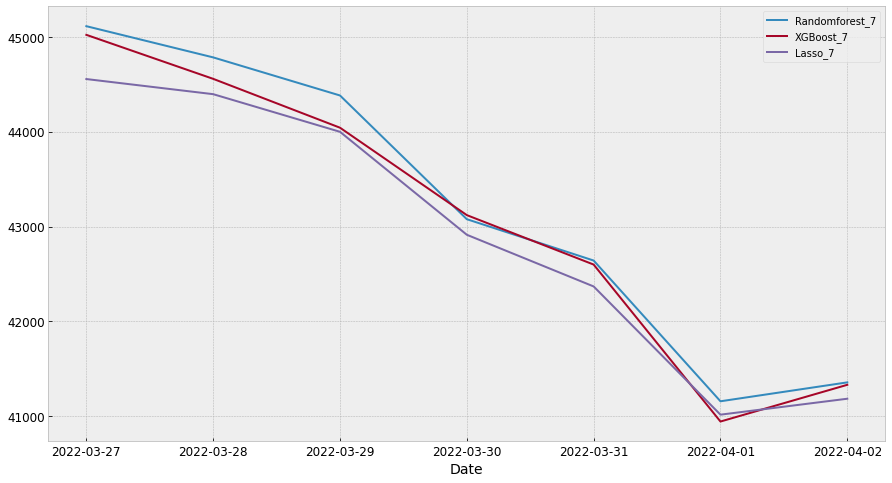

In [ ]:
df_Combine_7 = pd.DataFrame(predictionsDict_7)
df_Combine_Final_7 = pd.concat([df_next7days, df_Combine_7], axis=1)

df_Combine_Final_7.index = df_Combine_Final_7.Date
df_Combine_Final_7.drop('Date',axis=1,inplace=True)

df_Combine_Final_7.plot()
fig = plt.gcf()
fig.set_size_inches(15, 8)

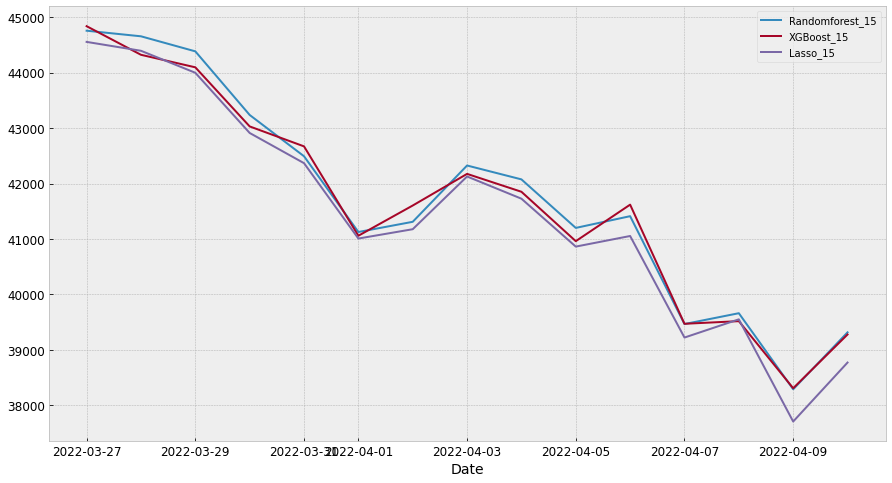

In [ ]:
df_Combine_15 = pd.DataFrame(predictionsDict_15)
df_Combine_Final_15 = pd.concat([df_next15days, df_Combine_15], axis=1)

df_Combine_Final_15.index = df_Combine_Final_15.Date
df_Combine_Final_15.drop('Date',axis=1,inplace=True)

df_Combine_Final_15.plot()
fig = plt.gcf()
fig.set_size_inches(15, 8)

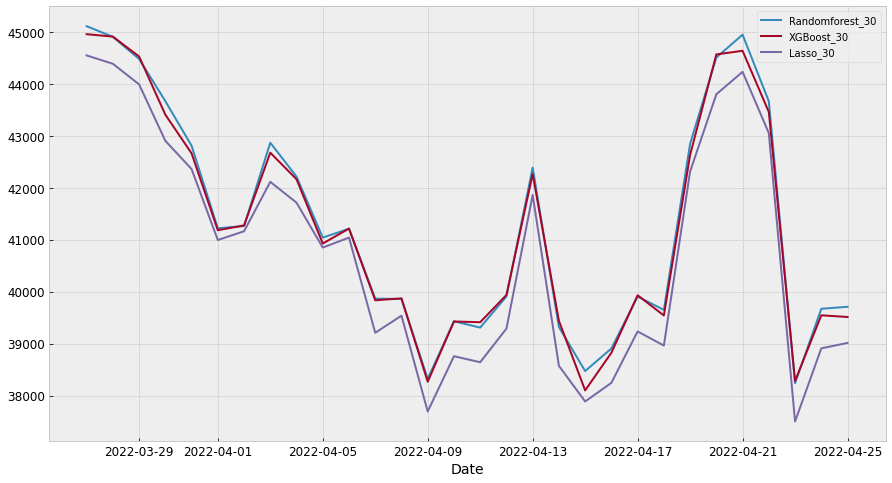

In [ ]:
df_Combine_30 = pd.DataFrame(predictionsDict_30)
df_Combine_Final_30 = pd.concat([df_next30days, df_Combine_30], axis=1)

df_Combine_Final_30.index = df_Combine_Final_30.Date
df_Combine_Final_30.drop('Date',axis=1,inplace=True)

df_Combine_Final_30.plot()
fig = plt.gcf()
fig.set_size_inches(15, 8)

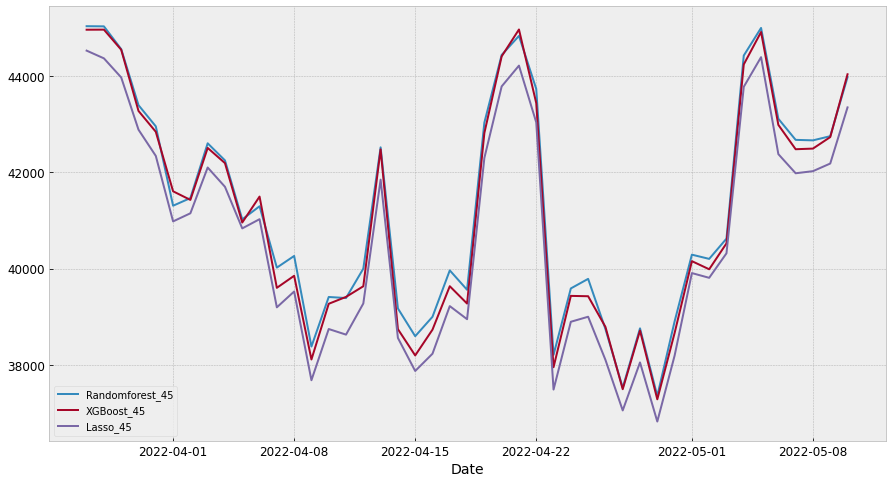

In [ ]:
df_Combine_45 = pd.DataFrame(predictionsDict_45)
df_Combine_Final_45 = pd.concat([df_next45days, df_Combine_45], axis=1)

df_Combine_Final_45.index = df_Combine_Final_45.Date
df_Combine_Final_45.drop('Date',axis=1,inplace=True)

df_Combine_Final_45.plot()
fig = plt.gcf()
fig.set_size_inches(15, 8)

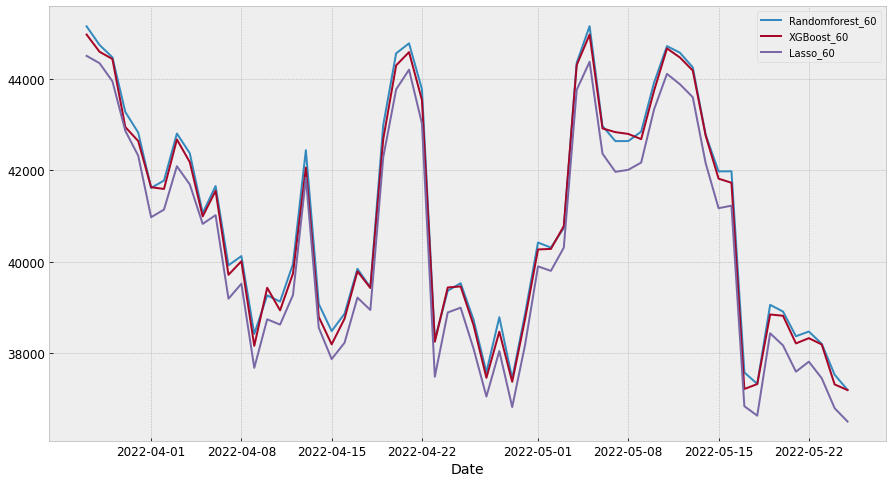

In [ ]:
df_Combine_60 = pd.DataFrame(predictionsDict_60)
df_Combine_Final_60 = pd.concat([df_next60days, df_Combine_60], axis=1)

df_Combine_Final_60.index = df_Combine_Final_60.Date
df_Combine_Final_60.drop('Date',axis=1,inplace=True)

df_Combine_Final_60.plot()
fig = plt.gcf()
fig.set_size_inches(15, 8)

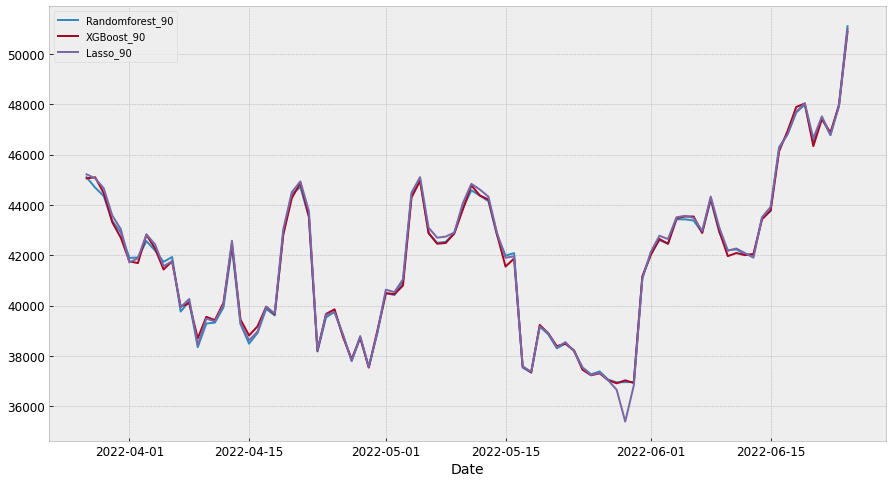

In [ ]:
df_Combine_90 = pd.DataFrame(predictionsDict_90)
df_Combine_Final_90 = pd.concat([df_next90days, df_Combine_90], axis=1)

df_Combine_Final_90.index = df_Combine_Final_90.Date
df_Combine_Final_90.drop('Date',axis=1,inplace=True)

df_Combine_Final_90.plot()
fig = plt.gcf()
fig.set_size_inches(15, 8)

## Save Output

In [ ]:
df_dictionary_7 = pd.DataFrame.from_dict(predictionsDict_7['XGBoost_7']).rename(columns={0:'Values'})
Final_df_Output_7 = pd.concat([df_next7days, df_dictionary_7], axis=1)

df_dictionary_15 = pd.DataFrame.from_dict(predictionsDict_15['XGBoost_15']).rename(columns={0:'Values'})
Final_df_Output_15 = pd.concat([df_next15days, df_dictionary_15], axis=1)

df_dictionary_30 = pd.DataFrame.from_dict(predictionsDict_30['XGBoost_30']).rename(columns={0:'Values'})
Final_df_Output_30 = pd.concat([df_next30days, df_dictionary_30], axis=1)

df_dictionary_45 = pd.DataFrame.from_dict(predictionsDict_45['XGBoost_45']).rename(columns={0:'Values'})
Final_df_Output_45 = pd.concat([df_next45days, df_dictionary_45], axis=1)

df_dictionary_60 = pd.DataFrame.from_dict(predictionsDict_60['XGBoost_60']).rename(columns={0:'Values'})
Final_df_Output_60 = pd.concat([df_next60days, df_dictionary_60], axis=1)

df_dictionary_90 = pd.DataFrame.from_dict(predictionsDict_90['XGBoost_90']).rename(columns={0:'Values'})
Final_df_Output_90 = pd.concat([df_next90days, df_dictionary_90], axis=1)

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
Final_df_Output_7.to_csv('/drive/My Drive/Bitcoin Prediction/next7days.csv',index=False)
Final_df_Output_15.to_csv('/drive/My Drive/Bitcoin Prediction/next15days.csv',index=False)
Final_df_Output_30.to_csv('/drive/My Drive/Bitcoin Prediction/next30days.csv',index=False)
Final_df_Output_45.to_csv('/drive/My Drive/Bitcoin Prediction/next45days.csv',index=False)
Final_df_Output_60.to_csv('/drive/My Drive/Bitcoin Prediction/next60days.csv',index=False)
Final_df_Output_90.to_csv('/drive/My Drive/Bitcoin Prediction/next90days.csv',index=False)